## Setup

Load libraries

In [1]:
import os
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import pyplot as plt


from typing import Dict, Union
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV

seed=10

## Load Data

In [3]:
raster = sio.loadmat('UAVSAR-ASO-WMesa.mat')

## Data Preprocessing

* Let's extract all useful variables

In [5]:
feb8_snow_depth=raster['r'][0][0][0]
feb21_snow_depth=raster['r'][0][1][0]
feb25_snow_depth=raster['r'][0][2][0]
sept26_bare_DEM=raster['r'][0][3][0]
sept26_veg_ht=raster['r'][0][4][0]
amplitude=raster['r2'][0][0][0]
unwrapped_phase=raster['r2'][0][1][0]
coherence=raster['r2'][0][2][0]
incidence_angle=raster['r2'][0][3][0]
elevation=raster['r2'][0][4][0]
wrapped_phase=raster['r2'][0][5][0]
easting=raster['r'][0][0][1]
northing=raster['r'][0][0][2]


# Create a dataframe
df = pl.DataFrame(
    {
    'amplitude': amplitude.ravel(),
    'unwrapped_phase': unwrapped_phase.ravel(),
    'coherence': coherence.ravel(),
    'incidence_angle': incidence_angle.ravel(),
    'bare_earth_dem': sept26_bare_DEM.ravel(),
    'vegetation_ht': sept26_veg_ht.ravel(),
    'wrapped_phase': wrapped_phase.ravel(),
    'snow_depth': feb8_snow_depth.ravel(),
    'elevation': elevation.ravel()
    }
)

df.head()

amplitude,unwrapped_phase,coherence,incidence_angle,bare_earth_dem,vegetation_ht,wrapped_phase,snow_depth,elevation
f64,f64,f64,f64,f32,f32,f64,f32,f64
0.424673,-10.83723,0.639889,0.929004,-9999.0,-9999.0,1.805211,-9999.0,2456.656494
0.424673,-10.83723,0.639889,0.929004,-9999.0,-9999.0,1.805211,-9999.0,2456.656494
0.38162,-10.83723,0.594642,0.929004,-9999.0,-9999.0,1.824319,-9999.0,2457.156494
0.38162,-10.83723,0.594642,0.926934,-9999.0,-9999.0,1.746802,-9999.0,2457.656494
0.369751,-10.83723,0.526593,0.924989,-9999.0,-9999.0,1.824319,-9999.0,2458.656616


* Data Cleaning

    - First `with_columns`: Process "snow_depth" column.
       * Replace values of 0 with `None`.
       * Replace values of 253 with `None`.
       * Replace values greater than 2 with `None`.
       * Keep all other values as they are.
    - Second `with_columns`: Process all columns.
       * Replace any value of -9999.0 with `None`.
    - `fill_nan`: Replace any remaining NaN values with `None`.

In [6]:
clean_data=(
    df.with_columns(
        [
            pl.when(pl.col('snow_depth') == 0)
            .then(None)
            .when(pl.col('snow_depth') == 253)
            .then(None)
            .when(pl.col('snow_depth') > 2)
            .then(None)
            .otherwise(pl.col('snow_depth')).keep_name()
        ]
    )
    .with_columns(
        [
            pl.when(pl.col('*') == -9999.0).then(pl.lit(None)).otherwise(pl.col('*'))
            .keep_name()
        ]
    )
    .fill_nan(None)
)

clean_data.head()

amplitude,unwrapped_phase,coherence,incidence_angle,bare_earth_dem,vegetation_ht,wrapped_phase,snow_depth,elevation
f64,f64,f64,f64,f32,f32,f64,f32,f64
0.424673,-10.83723,0.639889,0.929004,null,null,1.805211,null,2456.656494
0.424673,-10.83723,0.639889,0.929004,null,null,1.805211,null,2456.656494
0.38162,-10.83723,0.594642,0.929004,null,null,1.824319,null,2457.156494
0.38162,-10.83723,0.594642,0.926934,null,null,1.746802,null,2457.656494
0.369751,-10.83723,0.526593,0.924989,null,null,1.824319,null,2458.656616


## Plotting the variables

In [7]:
# create a folder to save the plots

if not os.path.exists('plots'):
    os.makedirs('plots')
else:
    print('Folder already exists')

Folder already exists


In [9]:
# creating a function to plot the data

def plot_var(variable, var_name, clims, pi_cbar=False):
    """
    A function that Plots a variable/remote sensing parameters with a colorbar and
    axis labels on a 2D grid. The colorbar limits are set by the user. The x and y axis
    are set to the easting and northing of the raster (UAVSAR) data.

    Parameters
    ----------
    variable : 2D array
        A two-dimensional array representing the variable to be plotted.
    var_name : str
        A string representing the title of the plot, typically the name of the variable.
    clims : tuple or list of two elements
        A tuple or list containing two elements representing the minimum and maximum values of the color scale.

    Returns
    -------
    None

    The function generates a plot using matplotlib, with UTM Zone 13 Easting and Northing as axes.
    The input variable is represented as color intensity on the plot. The color scale is controlled
    by the 'clims' parameter

    Example
    -------
    >>> plot_var(np.array([[1,2], [3,4]]), 'Example Variable', [1, 4])
    """


    extent=[
        easting.min(), easting.max(),
        northing.max(),northing.min()
    ]
    plt.imshow(variable, extent=extent, aspect='auto')
    ax = plt.gca()
    ax.invert_yaxis()
    plt.title(var_name, fontsize=10)
    plt.xlabel('UTM Zone 13 Easting [m]', fontsize=10)
    plt.ylabel('UTM Zone 13 Northing [m]', fontsize=10)
    plt.clim(clims[0], clims[1])

    if pi_cbar:
      cbar=plt.colorbar()
      cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
      cbar.set_ticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
    else:
      plt.colorbar()


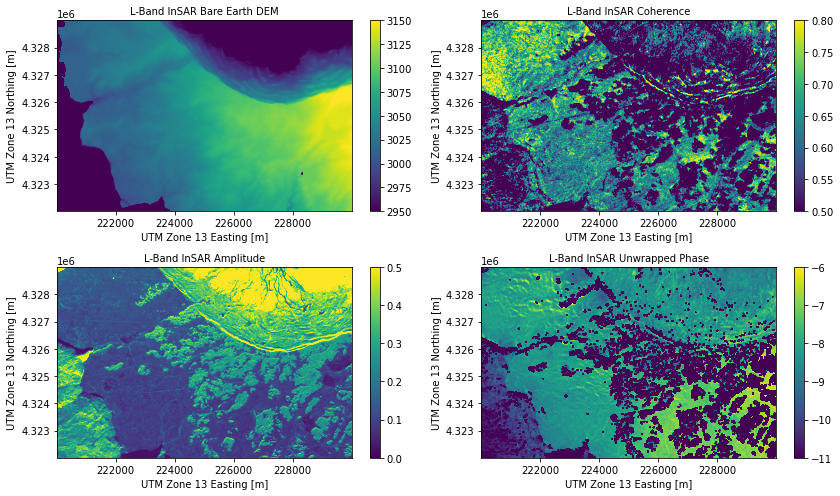

In [13]:
variables=[
    sept26_bare_DEM, coherence,
    amplitude, np.nan_to_num(unwrapped_phase, nan=-9999.0)
]

labels=[
    'L-Band InSAR Bare Earth DEM', 'L-Band InSAR Coherence',
    'L-Band InSAR Amplitude', 'L-Band InSAR Unwrapped Phase'
]

clims=[
    (2950, 3150), (0.5, 0.8),
    (0, 0.5), (-11, -6)
]

plt.figure(figsize=(12,7))
for j in range(1,5):
    ax=plt.subplot(2,2, j)
    plot_var(variables[j-1], labels[j-1], clims[j-1])
plt.tight_layout()
plt.savefig('plots/insar_variables.png', dpi=300)

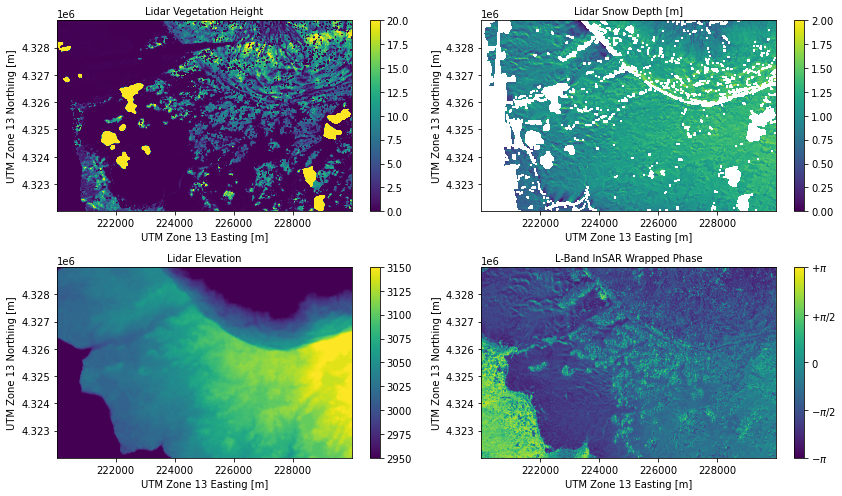

In [16]:
# reshape snow depth for plotting
shape=feb8_snow_depth.shape
clean_depth=clean_data.select('snow_depth').to_numpy().reshape(shape)

variables2=[
    sept26_veg_ht, clean_depth,
    elevation, wrapped_phase
]

labels2=[
    'Lidar Vegetation Height', 'Lidar Snow Depth [m]',
    'Lidar Elevation', 'L-Band InSAR Wrapped Phase'
]

clims2=[
    (0, 20), (0, 2),
    (2950, 3150), (-np.pi, np.pi)
]

plt.figure(figsize=(12,7))
for j in range(1,5):
    ax=plt.subplot(2,2, j)
    if j==4:
      plot_var(variables2[j-1], labels2[j-1], clims2[j-1], pi_cbar=True)
    else:
      plot_var(variables2[j-1], labels2[j-1], clims2[j-1])
plt.tight_layout()

plt.savefig('plots/lidar_variables.png', dpi=300)